In [1]:
import numpy as np
import pandas as pd
import scipy.io as spio
import math
import matplotlib.pyplot as plt
%matplotlib inline

### Neural Network with Forward and Backward Propagation

In [2]:
input_layer_size = 400
num_labels = 10

In [3]:
mat = spio.loadmat("/Users/devin/ML/machine-learning-ex4/ex4/ex4data1.mat")

In [4]:
X = mat['X']
y = mat['y'].flatten()
m = len(y)

In [5]:
rand_indices = np.random.permutation(m)
sel = X[rand_indices[:100]]

In [6]:
def display_data(X,example_width=None):
    if example_width is None:
        example_width = int(round(np.sqrt(X.shape[1])))
    m, n = X.shape
    example_height = int(n/example_width)    
    display_rows = math.floor(np.sqrt(m));
    display_cols = math.ceil(m / display_rows)
    pad = 1
    display_array = - np.ones((pad + display_rows * (example_height + pad),pad + display_cols * (example_width + pad)))
    curr_ex = 0
    for j in range(0,display_rows):
        for i in range(0,display_cols):
            if curr_ex >= m:
                break
            max_val = max(abs(X[curr_ex, :]))
            rows = pad + (j) * (example_height + pad)
            cols = pad + (i) * (example_width + pad)
            display_array[rows:example_height+rows,cols:example_width+cols] = np.reshape(
                X[curr_ex, :], (example_height, example_width)).T / max_val
            curr_ex = curr_ex + 1 
        if curr_ex >= m:
            break
    plt.figure(figsize=(10,10))        
    ax = plt.subplot(111)
    ax.imshow(display_array,cmap='Greys')
    plt.axis('off')

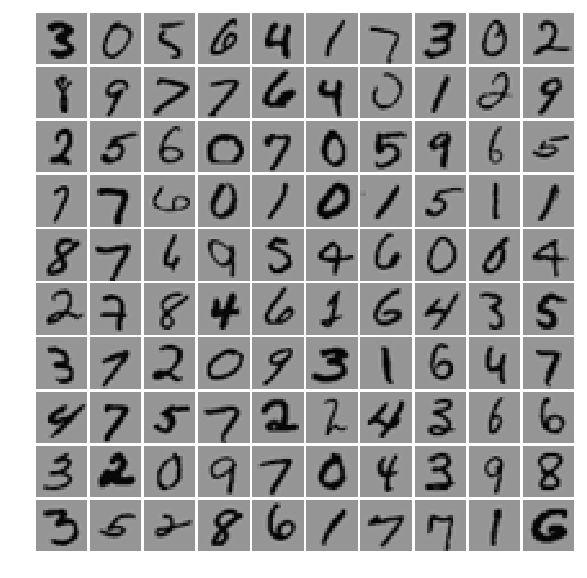

In [7]:
display_data(sel)

In [8]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [10]:
def sigmoid_gradient(z):
    g = sigmoid(z)
    g = g * (1-g)
    return g

In [11]:
g = sigmoid_gradient(np.array([-1, -0.5, 0, 0.5, 1]))
print(g)

[ 0.19661193  0.23500371  0.25        0.23500371  0.19661193]


In [12]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size, 
                     num_labels, X, y, lamda):
    Theta1 = nn_params[:hidden_layer_size*(input_layer_size+1)].reshape(
        (hidden_layer_size, input_layer_size+1))
    Theta2 = nn_params[hidden_layer_size*(input_layer_size+1):].reshape(
        (num_labels, hidden_layer_size+1))
    m = X.shape[0]
    J = 0
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    
    #forward propagate
    a1 = np.concatenate((np.ones((m,1)),X),axis=1)
    z2 = a1.dot(Theta1.T)
    a2 = sigmoid(z2)
    a2 = np.concatenate((np.ones((m,1)), a2),axis=1)
    z3 = a2.dot(Theta2.T)
    a3 = sigmoid(z3)
    h = a3
    y_vectors = np.array([[x for x in range(1,num_labels+1)] == yi for yi in y])
    J = sum(sum((y_vectors * np.log(h) + (1-y_vectors)*np.log(1-h))))
    theta1_reg = sum(sum(Theta1[:,1:]**2))
    theta2_reg = sum(sum(Theta2[:,1:]**2))
    J = (J / -m) + ((lamda / (2*m))*(theta1_reg+theta2_reg))
    
    #back propogate
    for t in range(m):    
        d3 = h[t,:] - y_vectors[t,:]
        d2 = np.dot(Theta2.T,d3)[1:] * sigmoid_gradient(z2[t,:])
        Theta1_grad = Theta1_grad + np.dot(d2.reshape(d2.shape[0],1),a1[t,:].reshape(1,a1[t,:].shape[0]))
        Theta2_grad = Theta2_grad + np.dot(d3.reshape(d3.shape[0],1),a2[t,:].reshape(1,a2[t,:].shape[0]))
    Theta1_grad = Theta1_grad / m
    Theta1_grad[:,1:] = Theta1_grad[:,1:] + (lamda / m) * Theta1[:,1:]
    
    Theta2_grad = Theta2_grad / m
    Theta2_grad[:,1:] = Theta2_grad[:,1:] + (lamda / m) * Theta2[:,1:]
    grad = np.concatenate((Theta1_grad.flatten(),Theta2_grad.flatten()))
    
    return J, grad

In [13]:
thetas = spio.loadmat('/Users/devin/ML/machine-learning-ex3/ex3/ex3weights.mat')
Theta1 = thetas['Theta1']
Theta2 = thetas['Theta2']
nn_params = np.concatenate((Theta1.flatten(),Theta2.flatten()))

In [14]:
lamda = 0
J, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, 
                     num_labels, X, y, lamda)
print('Cost at parameters (loaded from ex4weights): (this value should be about 0.287629)', J)

Cost at parameters (loaded from ex4weights): (this value should be about 0.287629) 0.287629165161


In [15]:
lamda = 1
J, grad = nn_cost_function(nn_params, input_layer_size, hidden_layer_size, 
                     num_labels, X, y, lamda)
print('Cost at parameters (loaded from ex4weights): (this value should be about 0.383770)', J)

Cost at parameters (loaded from ex4weights): (this value should be about 0.383770) 0.383769859091


In [16]:
def randInitializeWeights(L_in, L_out):
    epsilon_init = .12
    W = np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return W

In [17]:
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

In [18]:
initial_nn_params = np.concatenate((initial_Theta1.flatten(),initial_Theta2.flatten()))

In [19]:
def debugInitializeWeights(fan_out, fan_in):
    W = np.zeros((fan_out, 1 + fan_in))
    W = np.sin([x for x in range(1,(fan_out*(1+fan_in)+1))]).reshape(W.T.shape).T / 10
    return W

In [20]:
def computeNumericalGradient(J,params):
    theta,args=params
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    numel = theta.shape[0]
    for p in range(numel):
        perturb[p] = e
        loss1, grad = J(theta - perturb,*args)
        loss2, grad = J(theta + perturb,*args)
        numgrad[p] = (loss2 - loss1) / (2*e)
        perturb[p] = 0
    return numgrad

In [21]:
def check_NN_Gradients(lamda=0):
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    X  = debugInitializeWeights(m, input_layer_size - 1)
    y = 1 + np.mod(np.array(range(1,m+1)),num_labels)
    nn_params = np.concatenate((Theta1.flatten(),Theta2.flatten()))

    args = [input_layer_size, hidden_layer_size, num_labels, X, y, lamda]
    
    J, grad = nn_cost_function(nn_params,*args)
    numgrad = computeNumericalGradient(nn_cost_function, (nn_params,args))

    for i in range(len(numgrad)):
        print(numgrad[i], grad[i],)

    diff = np.linalg.norm(numgrad-grad)/np.linalg.norm(numgrad+grad)

    print(
    '''
    The above two columns you get should be very similar.
    If your backpropagation implementation is correct, then
    the relative difference will be small (less than 1e-9).
    Relative Difference: %d
    ''' % diff)

In [22]:
check_NN_Gradients()

-0.00927825234642 -0.00927825235799
-3.04978708954e-06 -3.0497891352e-06
-0.000175060084207 -0.000175060082341
-9.62660640091e-05 -9.6266061953e-05
0.00889911959012 0.00889911959567
1.428694274e-05 1.42869442534e-05
0.000233146355555 0.000233146356525
0.000117982665859 0.000117982665796
-0.00836010761063 -0.00836010761746
-2.59383092782e-05 -2.59383100024e-05
-0.000287468728821 -0.000287468729345
-0.000137149704926 -0.000137149706034
0.00762813550326 0.00762813551083
3.69883212947e-05 3.69883234431e-05
0.000335320347045 0.000335320347216
0.000153247079471 0.0001532470816
-0.00674798369404 -0.00674798370032
-4.68759764338e-05 -4.68759768852e-05
-0.000376215587572 -0.000376215586743
-0.000166560296666 -0.000166560294197
0.314544970041 0.314544970054
0.164090818797 0.164090818795
0.164567932286 0.164567932288
0.158339333882 0.158339333884
0.151127527466 0.151127527466
0.149568334715 0.149568334717
0.111056588208 0.111056588217
0.057573649348 0.0575736493494
0.0577867378482 0.0577867378497

In [23]:
lamda = 3
check_NN_Gradients(lamda)
debug_J, grad  = nn_cost_function(nn_params, input_layer_size,
                          hidden_layer_size, num_labels, X, y, lamda)

print('''
    Cost at (fixed) debugging parameters (w/ lambda = {}: {}
    for lambda = 3, this value should be about 0.576051)'''.format(lamda, debug_J))

-0.00927825234642 -0.00927825235799
-0.0167679796781 -0.0167679796811
-0.060174472476 -0.0601744724754
-0.0173704650641 -0.0173704650619
0.00889911959012 0.00889911959567
0.0394334828657 0.0394334828674
-0.0319612287236 -0.0319612287235
-0.0575658668467 -0.057565866847
-0.00836010761063 -0.00836010761746
0.0593355564882 0.0593355564874
0.024922553481 0.0249225534803
-0.0451963845127 -0.0451963845123
0.00762813550326 0.00762813551083
0.0247640974349 0.0247640974379
0.0597717616868 0.0597717616889
0.00914587965806 0.00914587966138
-0.00674798369404 -0.00674798370032
-0.0326881426282 -0.0326881426302
0.0386410548203 0.0386410548227
0.0546101547472 0.0546101547495
0.314544970041 0.314544970054
0.118682669079 0.118682669077
0.203987128209 0.203987128211
0.12569806723 0.125698067231
0.176337549675 0.176337549676
0.132294135715 0.132294135717
0.111056588208 0.111056588217
3.81928666471e-05 3.81928696241e-05
0.117148232646 0.117148232647
-0.0040758827935 -0.00407588279206
0.113133142252 0.1131

In [24]:
import scipy.optimize as opt
lamda = 1
args = (input_layer_size, hidden_layer_size, num_labels, X, y, lamda)
options = {'maxiter':50,'disp':True}
nn_params = opt.minimize(nn_cost_function, initial_nn_params, args=args, method='CG', jac=True, options=options).x
Theta1 = nn_params[:hidden_layer_size*(input_layer_size+1)].reshape((hidden_layer_size, input_layer_size+1))
Theta2 = nn_params[hidden_layer_size*(input_layer_size+1):].reshape((num_labels, hidden_layer_size+1))

         Current function value: 0.467256
         Iterations: 50
         Function evaluations: 111
         Gradient evaluations: 111


### Visualize hidden layer

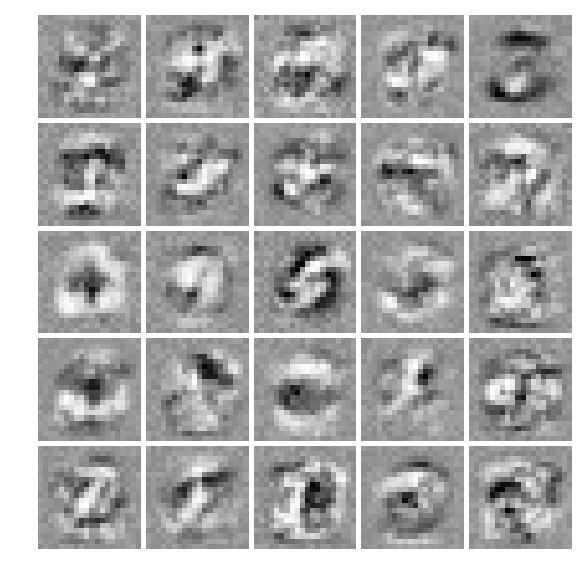

In [25]:
display_data(Theta1[:,1:])

In [26]:
def predict(Theta1, Theta2, X):

    m = X.shape[0]
    num_labels = Theta2.shape[0]

    p = np.zeros((m, 1))

    h1 = sigmoid(np.concatenate((np.ones((m, 1)), X), axis=1).dot(Theta1.T))
    h2 = sigmoid(np.concatenate((np.ones((m, 1)), h1), axis=1).dot(Theta2.T))
    p = np.argmax(h2,1) + 1
    return p

In [27]:
predictions = predict(Theta1, Theta2, X)

In [28]:
sum(predictions == y) / len(y)

0.96179999999999999

In [29]:
from sklearn.neural_network import MLPClassifier
input_layer_size  = 400
hidden_layer_size = 25
num_labels = 10

mat = spio.loadmat("/Users/devin/ML/machine-learning-ex3/ex3/ex3data1.mat")
X = mat['X']
y = mat['y']
y = y.flatten()
y[y==10] = 0

In [30]:
clf = MLPClassifier(hidden_layer_sizes=(hidden_layer_size,),activation='logistic',solver='lbfgs')
clf.fit(X,y)
predictions = clf.predict(X)
sum(predictions == y) / len(y)

1.0


Displaying Example Image


Neural Network Prediction: 3 (digit 3)



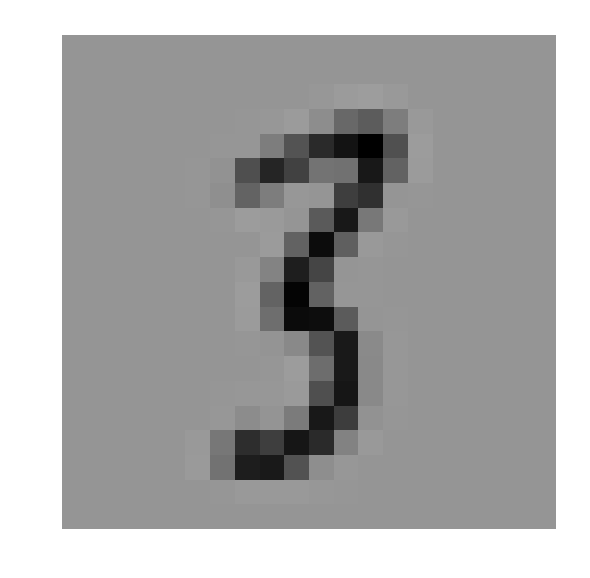

In [31]:
rp = np.random.permutation(len(X))

print('\nDisplaying Example Image\n')
display_data(X[rp[0], :].reshape((1,400)))
pred = predictions[rp[0]]
print('\nNeural Network Prediction: {} (digit {})\n'.format(pred, pred))